### Data Loading and Label Mapping

In [1]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification,pipeline
from googlesearch import search
from bs4 import BeautifulSoup
import requests
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
from scraping_selenium import people_also_ask
import re

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('Test_dataset(FINAL).csv')
df

,Headline,Source,Question_phi,Question_Mistral,Label
0,NASA’s Perseverance rover finds its first poss...,sciencenews.org,"""Has NASA's Perseverance rover discovered evid...","""Has NASA officially announced the discovery o...",True
1,Sepsis tests take days putting patients at ri...,sciencenews.org,"""What is the current average wait time for sep...","""Is there a recent study or research that show...",True
2,Nasa's DART asteroid unlocks complex history o...,https://timesofindia.indiatimes.com/,"""What is the history of NASA's DART mission an...","""Has NASA's DART mission provided evidence of ...",True
3,Say goodbye to back pain patients go for adva...,https://timesofindia.indiatimes.com/,"""What are the benefits of advanced endoscopy s...","""Has 'advanced endoscopy spine surgery for sci...",True
4,Neurodivergent children more likely to develop...,https://timesofindia.indiatimes.com/,"""What does the study find about the likelihood...","""Is there a peer-reviewed study titled 'Neurod...",True
...,...,...,...,...,...
683,"""Google's parent company faces UK investigatio...",Synthetically Generated,"""Has Google's parent company been investigated...","""Has Alphabet Inc., Google's parent company, b...",False
684,"""Intel announces hiring spree to fund recovery...",Synthetically Generated,"""What is the current hiring status of Intel as...","""Has Intel announced a hiring spree to fund re...",False
685,"""Ola Electric IPO grey market premium skyrocke...",Synthetically Generated,"""What is the current grey market premium for O...","""Has the Ola Electric IPO grey market premium ...",False
686,"""Japan's Nikkei 225 Index Soars 12.4%, Its Big...",Synthetically Generated,"""What was the percentage increase in Japan's N...","1. ""Is there a news article from a reliable so...",False


In [3]:
# Shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,Headline,Source,Question_phi,Question_Mistral,Label
0,"""Keely Hodgkinson fails to break the record, f...",Synthetically Generated,"""Did Keely Hodgkinson finish seventh in the 80...","""Keely Hodgkinson 800m race results from [even...",False
1,Kendrick Lamar drops 'Not Like Us' music video...,https://www.nbcnews.com/,"""What is the title of the music video Kendrick...","""Is there a recent music video release by Kend...",True
2,"""Simone Biles regrets her performance in floor...",Synthetically Generated,"""Did Simone Biles express regret over her perf...","""Has Simone Biles made a public statement expr...",False
3,U.S. journalist Evan Gershkovich freed from Ru...,https://www.cnbc.com,"""What was the name of the U.S. journalist who ...","""Has U.S. journalist Evan Gershkovich been off...",True
4,"""The first Emily Henry adaptation, People We M...",Synthetically Generated,"""What is the critical reception of the first E...","""Has 'People We Meet on Vacation', the first E...",False


In [4]:
df['Label'].value_counts()

Label
False    344
True     344
Name: count, dtype: int64

<Axes: ylabel='Label'>

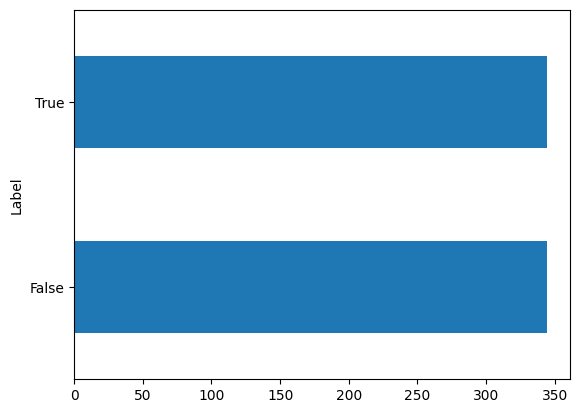

In [5]:
df['Label'].value_counts().plot(kind='barh')

Article Pipeline Utility

In [6]:

def get_top_links(query, num_links=1):
    linksgot = []
    try:
        # Perform Google search and get the top links
        search_results = search(query, num_results=num_links)

        # Print the top links
        for i, link in enumerate(search_results, start=1):
            linksgot.append(link)
    except Exception as e:
        print(f"An error occurred: {e}")
    return linksgot


def get_title_and_content(search_query_results):
    article_titles = []
    article_content = []
    if search_query_results:
        for results in search_query_results:
            try:
                # Send a request to the URL and get the HTML content
                response = requests.get(results)
                soup = BeautifulSoup(response.content, 'lxml')

                currentp = ""
                # Scrape <p> tags
                p_tags = soup.find_all('p')
                for p in p_tags:
                    currentp += p.text
                currentp = currentp[:1000]
                currentp = currentp.replace('\n', ' ')
                currentp = re.sub(r'\s+', ' ', currentp)
                article_content.append(currentp)

                currenth1 = ""
                # Scrape <h1> tags
                h1_tags = soup.find_all('h1')
                for h1 in h1_tags:
                    currenth1 += h1.text

                article_titles.append(currenth1)

            except Exception as e:
                print(f"An error occurred: {e}")
    return article_titles, article_content


# Get the titles and contents
def make_data(search_query_results):
    titles, contents = get_title_and_content(
        get_top_links(search_query_results))

    # Create a pandas DataFrame
    data = {'Title': titles, 'Content': contents}
    df = pd.DataFrame(data)
    return df

### QnA Pipeline

In [7]:
#Load FactCC Model pipeline
pipe = pipeline(model="manueldeprada/FactCC", task="text-classification", max_length=512)

/opt/homebrew/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [8]:
#To answer the question generated by LLM via google
def google_search(query):
    headers = {
        'User-agent':
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.67 Safari/537.36'
    }
    
    # Perform the Google search
    search_url = f'https://www.google.com/search?q={query}'
    html = requests.get(search_url, headers=headers)
    
    # Parse the HTML response
    soup = BeautifulSoup(html.text, 'html.parser')
    
    #extract answer from summary answer on google
    if soup.select_one('.hgKElc'):
        answer = soup.select_one('.hgKElc').text 

    # Extract the answer (assuming it's in a specific class) -> QUICK ANSWER BOX
    elif soup.select_one('.DI6Ufb'):
        answer = soup.select_one('.DI6Ufb')
        answer = answer.find(class_='Z0LcW t2b5Cf').text
        answer=query+' '+answer
    
    elif not soup.select_one('.DI6Ufb'):
        result=people_also_ask(search_url)
        # print("Result of the Scraping",result)
        if len(result)==2:
            answer=f'{result[0]} {result[1]}'
        else:
            #incase people also asked also comes empty we revert to the article pipeline
            scraped_df = make_data(query)
            scraped_df.dropna(inplace=True)

            # Convert the 'Content' column to strings
            scraped_df['Content'] = scraped_df['Content'].astype(str)

            # Sort the DataFrame based on the length of the strings in the 'Content' column
            scraped_df = scraped_df.sort_values(by='Content', key=lambda x: x.str.len(), ascending=False)

            if len(scraped_df) == 0 or not scraped_df['Content'][0] or '403 Forbidden' in scraped_df['Content'][0] or '403 Forbidden' in scraped_df['Title'][0] :
                #Could not retrieve articles related to headline, Could possibly be a false claim OR Scraper got blocked/forbidden
                return str('Cannot retrieve articles, most likely to be false')

            scraped_content = (
            f"{scraped_df['Title'][0]} \n{scraped_df['Content'][0]}")
            answer = scraped_content
    return answer

In [9]:
def FactCC_QNA(input_headline):
    quickSearchAnswer = google_search(input_headline)

    #compare scraped info as source and headline as the claim
    ans = pipe([[[quickSearchAnswer,input_headline]]], truncation=True, padding='max_length')

    print('Input headline : ',input_headline)
    print('Scraped Answer : ',quickSearchAnswer)
    if ans[0]['label'] == 'CORRECT':
        return True
    else:
        return False

In [10]:
model_decision = FactCC_QNA(df['Headline'][0])
actual_decision = df['Label'][0]
print(model_decision,actual_decision)
if (model_decision) == (actual_decision):
    print('Correct Decision')
else:
    print('Incorrect Decision')

People Also Asked questions dont exist for this category
Input headline :  "Keely Hodgkinson fails to break the record, finishing seventh in a disappointing 800m race."
Scraped Answer :  GOLD for Keely Hodgkinson - Days 5-6 at the Olympic Games 
Wednesday 7 August 2024As we journey further into the track and field action at the Olympic Games, the excitement builds with more medals on offer for our English athletes. Day five saw 800m queen Keely Hodgkinson (Leigh, Trevor Painter), execute an exemplary race to etch her name into the history books as Olympic champion!Arguably one of the most anticipated races of the Olympics, all eyes were on Keely Hodgkinson on Monday evening as she toed the line in the 800m final. Qualifying with the fastest time on paper, she was the hot favourite and she indeed lived up to that, executing the perfect race to take the title. From the break Keely was battling for front spot, remaining composed. Hitting the bell in just over 58 seconds, there was plenty 

In [11]:
df = df[:10] #For testing

In [12]:
df

,Headline,Source,Question_phi,Question_Mistral,Label
0,"""Keely Hodgkinson fails to break the record, f...",Synthetically Generated,"""Did Keely Hodgkinson finish seventh in the 80...","""Keely Hodgkinson 800m race results from [even...",False
1,Kendrick Lamar drops 'Not Like Us' music video...,https://www.nbcnews.com/,"""What is the title of the music video Kendrick...","""Is there a recent music video release by Kend...",True
2,"""Simone Biles regrets her performance in floor...",Synthetically Generated,"""Did Simone Biles express regret over her perf...","""Has Simone Biles made a public statement expr...",False
3,U.S. journalist Evan Gershkovich freed from Ru...,https://www.cnbc.com,"""What was the name of the U.S. journalist who ...","""Has U.S. journalist Evan Gershkovich been off...",True
4,"""The first Emily Henry adaptation, People We M...",Synthetically Generated,"""What is the critical reception of the first E...","""Has 'People We Meet on Vacation', the first E...",False
5,"""Johnny Cash statue to be removed from U.S. Ca...",Synthetically Generated,"""Is there a confirmed plan to remove a statue ...","""Has there been an official announcement regar...",False
6,"""PCB chief Mohsin Naqvi denies any alterations...",Synthetically Generated,"""Has PCB chief Mohsin Naqvi confirmed or denie...","""Has Mohsin Naqvi, the PCB chief, issued a sta...",False
7,"India's July diesel, jet fuel exports to Singa...",https://economictimes.indiatimes.com/,"""What is the current trend in India's diesel a...","""Has India's diesel and jet fuel exports to Si...",True
8,"""Japan's Nikkei hits record high since 1987 Bl...",Synthetically Generated,"""What was the highest point of Japan's Nikkei ...","""Has the Nikkei index reached a record high si...",False
9,Russia releases Evan Gershkovich and Paul Whel...,https://edition.cnn.com,"""What is the current status of Evan Gershkovic...","""Has Russia officially confirmed the release a...",True


In [ ]:
# Initialize lists to store predictions and actual values
predictions = []
actuals = []

# Iterate over each row in the dataframe
for index, row in df.iterrows():
    model_decision = FactCC_QNA(row['Headline'])
    actual_decision = row['Label']
    predictions.append((model_decision))
    actuals.append((actual_decision))
    print(f"Index: {index}, Model Decision: {model_decision}, Actual Decision: {actual_decision}")
    print(f"------------------------------------------------------------------------------------")
    time.sleep(5)

# Calculate the metrics
accuracy = accuracy_score(actuals, predictions)
precision = precision_score(actuals, predictions, pos_label=True)
recall = recall_score(actuals, predictions, pos_label=True)
f1 = f1_score(actuals, predictions, pos_label=True)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
